In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
# reading required csv files
managersDF = pd.read_csv('Managers.csv')
#teamDF = pd.read_csv('Teams.csv')
masterDF = pd.read_csv('Master.csv')
TeamsDF = pd.read_csv('Teams.csv')

### Data Wrangling 

* There are no missing values in the main dataframe.
* Since the main dataframe managersDF does not have full names of teams and managers, I have used other dataframes 'masterDF' and 'TeamsDF' for the information.
* Further, some teams had several names in the 'TeamsDF'. E.g. for team code 'CHN' the team had names such as 'Chicago White Stockings', 'Chicago Colts', 'Chicago Orphans', and 'Chicago Cubs'. To deal with this situation, I have used a function to get the name, corresponding to the latest year for teamID.

In [3]:
managersDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3405 entries, 0 to 3404
Data columns (total 10 columns):
playerID    3405 non-null object
yearID      3405 non-null int64
teamID      3405 non-null object
lgID        3338 non-null object
inseason    3405 non-null int64
G           3405 non-null int64
W           3405 non-null int64
L           3405 non-null int64
rank        3404 non-null float64
plyrMgr     3405 non-null object
dtypes: float64(1), int64(5), object(4)
memory usage: 266.1+ KB


## 1) Analaysis on managers, teams, and managers' average tenure


### Finding total number of managers and teams

In [4]:
managerNum = pd.unique(managersDF['playerID'])
teamNum = pd.unique(managersDF['teamID'])

print("There are " + str(len(managerNum)) +" unique managers in the dataset.")
print("There are " + str(len(teamNum)) +" unique teams in the dataset.")

There are 696 unique managers in the dataset.
There are 149 unique teams in the dataset.


### Finding managers with more than one team

I have grouped managers to teams to check if any manager is with more than one team

In [5]:
manager_groupDF = managersDF.groupby(['playerID', 'teamID']).G.agg(['count'])
manager_groupDF.head()

count
playerID  teamID       
actama99  CLE         3
          WAS         3
adairbi99 CHA         1
adcocjo01 CLE         1
addybo01  CN1         1

In [6]:
# since manager_groupDF has multi-index count, I have converted into a seperated DataFrame to get teamID count 
tempDF = manager_groupDF.reset_index().groupby('playerID')['teamID'].nunique()
managerByTeamCount = tempDF.add_suffix('').reset_index()
managerByTeamCount.rename(columns={'teamID': 'Teams_Managed'}, inplace=True)

In [7]:
managerByTeamCount.head()

,playerID,Teams_Managed
0,actama99,2
1,adairbi99,1
2,adcocjo01,1
3,addybo01,2
4,allenbo01,2


In [8]:
#Calculating average numbers of teams managed / manager
avgTeams = managerByTeamCount.mean().round(2)
avgTeams

Teams_Managed    1.71
dtype: float64

In [10]:
# I have grouped managers by number of teams managed by them, and then presented it in form of frequency and percentage

managedTeams = managerByTeamCount.groupby(['Teams_Managed']).agg(['count'])

managedTeamsSum = managedTeams.playerID['count'].sum()
managedTeams['Count_Percentage'] =  (managedTeams.playerID['count']/managedTeamsSum)*100

managedTeams

,playerID,Count_Percentage
,count,
Teams_Managed,,
1,425,61.063218
2,153,21.982759
3,59,8.477011
4,31,4.454023
5,18,2.586207
6,7,1.005747
7,2,0.287356
9,1,0.143678


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000ACA3188C18>], dtype=object)

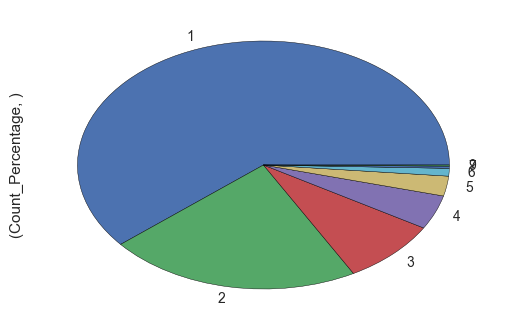

In [11]:
managedTeams[['Count_Percentage']].plot(kind='pie',subplots=True, legend=None, label='Teams Managed')

Creating a function to find manager's name against his id

In [12]:
def findName (id):
    record = masterDF.loc[masterDF['playerID'].isin([id])]
    fName = record.nameFirst
    lName = record.nameLast
    fullName = fName+" "+lName
    return pd.Series(dict(col2=fullName))

creating a function to find a team's name, against it's id

Since one teamID can have more than one name over a period of time (e.g. CHN), I have considered the latest name

In [13]:
def getTeam(id):
    TeamsDF.sort_values(by='yearID', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
    team_ids = TeamsDF[TeamsDF['teamID'].isin([id])]
    team_row = team_ids.loc[[team_ids['yearID'].argmax()]]
    team_name = team_row.name
    return(team_name)

In [14]:
managerByTeamCount['Manager Name'] = managerByTeamCount.playerID.apply(lambda x : findName(x))

In [15]:
managerByTeamCount.head()

,playerID,Teams_Managed,Manager Name
0,actama99,2,55 Manny Acta dtype: object
1,adairbi99,1,56 Bill Adair dtype: object
2,adcocjo01,1,95 Joe Adcock dtype: object
3,addybo01,2,100 Bob Addy dtype: object
4,allenbo01,2,186 Bob Allen dtype: object


### Finding Managers who managed the maximum teams

In [16]:
managerByTeamCount.sort_values(by='Teams_Managed', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')

In [17]:
managerByTeamCount[0:10]

,playerID,Teams_Managed,Manager Name
178,fergubo01,9,5202 Bob Ferguson dtype: object
89,chapmja01,7,2838 Jack Chapman dtype: object
22,bancrfr99,7,691 Frank Bancroft dtype: object
158,dykesji01,6,4731 Jimmy Dykes dtype: object
358,loftuto01,6,9983 Tom Loftus dtype: object
91,clappjo01,6,2990 John Clapp dtype: object
557,schmegu99,6,15168 Gus Schmelz dtype: object
417,mcnamjo99,6,11225 John McNamara dtype: object
282,hornsro01,6,7858 Rogers Hornsby dtype: object
671,willidi02,6,18240 Dick Williams dtype: object


### Tenure of managers with different teams

I have grouped the data, first by Manager Id and then by TeamId to get the count of number of years each manager was with one team. 

The count is then copied as a seperate column in another dataframe, and then the frequency of specific counts is calculated to create a chart.

In [18]:
manager_groupDF = managersDF.groupby(['playerID', 'teamID']).G.agg(['count'])
#this groups by playerID and teamId and get the count

In [19]:
manager_groupDF.head()

count
playerID  teamID       
actama99  CLE         3
          WAS         3
adairbi99 CHA         1
adcocjo01 CLE         1
addybo01  CN1         1

In [20]:
#Calculating average tenure of all managers
avgTenure = manager_groupDF.mean().round(2)
avgTenure

count    2.87
dtype: float64

In [21]:
managerCount = manager_groupDF.add_suffix('_Count').reset_index()
#This creates the count as a seperate column in the managerCount data frame

In [22]:
managerCountDF = managerCount.groupby(['count_Count']).agg(['count'])

In [23]:
managerContSum = managerCountDF.playerID['count'].sum()

In [26]:

managerCountDF['Count_Percentage'] =  (managerCountDF.playerID['count']/managerContSum)*100
# Now we are taking frequncies(counts) of the original counts, and finding their percentages

In [27]:
managerCountDF.index.names = ['Tenure']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000AC98FB0F28>], dtype=object)

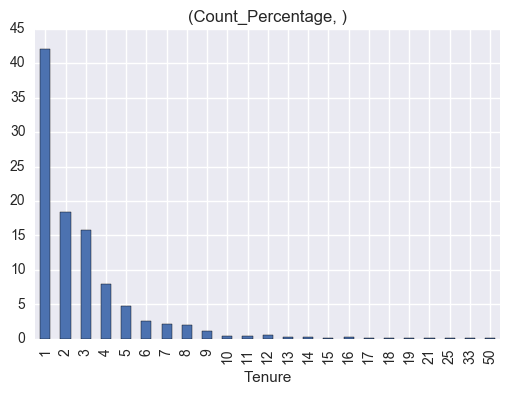

In [28]:
managerCountDF[['Count_Percentage']].plot(kind='bar',subplots=True, legend=None, label='Count_pct')

_Note: There are 696 managers, but 1,187 unique manager-team combination_

In [29]:
managerCountDF

,playerID,teamID,Count_pct,Count_Percentage
,count,count,,
Tenure,,,,
1,500,500,42.122999,42.122999
2,219,219,18.449874,18.449874
3,188,188,15.838248,15.838248
4,95,95,8.003370,8.003370
5,56,56,4.717776,4.717776
6,30,30,2.527380,2.527380
7,25,25,2.106150,2.106150
8,23,23,1.937658,1.937658


### Finding managers with highest tenures

In [30]:
manager_groupDF.sort_values(by='count', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')


In [31]:
manager_groupDF.head()

,,count
playerID,teamID,
mackco01,PHA,50
mcgrajo01,NY1,33
coxbo01,ATL,25
lasorto01,LAN,21
alstowa01,LAN,19


In [32]:
# Finding manager with highest tenure
findName ('mackco01')

col2    10266    Connie Mack
dtype: object
dtype: object

In [33]:
# Finding the team he worked with
getTeam ('PHA')

1258    Philadelphia Athletics
Name: name, dtype: object

## 2) Comparing manager's tenure and team's average ranking

* Since some managers worked with more than one team, and some teams had more than one manager, in order to find unique combinations of managers and teams, I have created a new column 'Player_Team' -  which assigns a specific manager to a specific team. 
* Further, I have added another column for winning % (win_pct), which is a percentage of games won over games played.

In [34]:
managersDF['Player_Team'] = managersDF['playerID']+","+managersDF['teamID']
managersDF['win_pct'] = (managersDF['W']/managersDF['G'])*100
managersDF.head()

,playerID,yearID,teamID,lgID,inseason,G,W,L,rank,plyrMgr,Player_Team,win_pct
0,wrighha01,1871,BS1,NaN,1,31,20,10,3.0,Y,"wrighha01,BS1",64.516129
1,woodji01,1871,CH1,NaN,1,28,19,9,2.0,Y,"woodji01,CH1",67.857143
2,paborch01,1871,CL1,NaN,1,29,10,19,8.0,Y,"paborch01,CL1",34.482759
3,lennobi01,1871,FW1,NaN,1,14,5,9,8.0,Y,"lennobi01,FW1",35.714286
4,deaneha01,1871,FW1,NaN,2,5,2,3,8.0,Y,"deaneha01,FW1",40.000000


In [35]:
#Finding unique Player_team >>> Answer: 1187
uniqueManager = pd.unique(managersDF['Player_Team'])


In [36]:
len(uniqueManager)

1187

Now, for every unique Player_Team, I have created a small array that filters the years for which a manager was with one team and calculates the average ranking during those years. 

It also sorts the years in chronological order, and finds the team's ranking in the first year, when the manager joined

In [37]:
newDF = pd.DataFrame()

for manger_id in uniqueManager:
    managerTeam = managersDF.loc[managersDF['Player_Team'] == manger_id]
    idSplit = manger_id.split(",")
    managerID = idSplit[0]
    managerName = findName (managerID)
    teamID = idSplit[1]
    teamName = getTeam (teamID)
    minYear = managerTeam['yearID'].min() 
    minYearRank = managerTeam['rank'][managerTeam['yearID'] == minYear].values[0]
    avgRanking = managerTeam['rank'].mean()
    tenure = len(managerTeam)
    newDF = newDF.append({'manager_Team': manger_id, 'joining_Year': minYear, 'join_Year_Rank': minYearRank, 'average_Ranking': avgRanking, 'manager_Tenure': tenure, 'manager_Name': managerName, 'team_Name': teamName}, ignore_index=True)

In [38]:
# Adding a new column of increase/decrease in average ranking
newDF['rank_Change'] = 0 - (newDF.average_Ranking - newDF.join_Year_Rank).round(0)

In [39]:
# Filtering managers with tenure of more than 2 years
finalDF = newDF[newDF.manager_Tenure >= 2]

Now, from NewDF, all the managers with tenure of atleast 2 years have been selected, and the increase/ decreasse in their average ranking has been calculated.

Logic behind filtering managers with tenure of only 1 years is that team's average ranking will be same as that on the year of joining.

Then, top managers witnessing highest increase in average ranking have been filtered.

Further, correlation between a manager's tenure and increase in average ranking has been calculated  

In [40]:
rank_Increase = len(finalDF[finalDF.rank_Change > 0]) 
rank_Decrease = len(finalDF[finalDF.rank_Change < 0]) 
rank_Same = len(finalDF[finalDF.rank_Change == 0]) 

In [41]:
print ("Increase / decrease in a team's average ranking over a manager's tenure:")
print(" ")
print("Average ranking of " + str(rank_Increase) + " teams increased during their managers' tenure")
print("Average ranking of " + str(rank_Decrease) + " teams decreased during their managers' tenure")
print("Average ranking of " + str(rank_Same) + " teams did not change during their managers' tenure")

Increase / decrease in a team's average ranking over a manager's tenure:
 
Average ranking of 229 teams increased during their managers' tenure
Average ranking of 213 teams decreased during their managers' tenure
Average ranking of 245 teams did not change during their managers' tenure


### Finding top managers with highest ranking increase

In [42]:
newDF.sort_values(by='rank_Change', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')


In [43]:
newDF.head()

,average_Ranking,join_Year_Rank,joining_Year,manager_Name,manager_Team,manager_Tenure,team_Name,rank_Change
724,3.714286,10.0,1966.0,col2 4706 Leo Durocher dtype: object dty...,"durocle01,CHN",7.0,"2792 Chicago Cubs Name: name, dtype: object",6.0
262,3.571429,10.0,1892.0,col2 6955 Ned Hanlon dtype: object dtype...,"hanlone01,BLN",7.0,"363 Baltimore Orioles Name: name, dtype: ob...",6.0
742,4.000000,9.0,1968.0,col2 7681 Gil Hodges dtype: object dtype...,"hodgegi01,NYN",4.0,"2795 New York Mets Name: name, dtype: object",5.0
352,2.515152,8.0,1902.0,col2 11087 John McGraw dtype: object dty...,"mcgrajo01,NY1",33.0,"1305 New York Giants Name: name, dtype: object",5.0
131,5.000000,10.0,1884.0,col2 13378 Horace Phillips dtype: object...,"phillho99,PT1",3.0,"185 Pittsburg Alleghenys Name: name, dtype:...",5.0


### Finding correlation between manager's tenure and change in average ranking 

In [44]:
def correlation(x,y):

    std_x = (x-x.mean()) / x.std(ddof=0)
    std_y = (y-y.mean()) / y.std(ddof=0)
    
    return (std_x * std_y).mean()

In [45]:
corr = (correlation(newDF['manager_Tenure'],newDF['rank_Change']))
print("Correlation betwwen managers' tenure and change in teams' ranking is: "+ str(corr))

Correlation betwwen managers' tenure and change in teams' ranking is: 0.17897903528037765


## 3) Comparing manager's tenure and team's winning %

Now, for every unique Player_Team, I have created a small array that filters the years for which a manager was with one team and calculates the average winning % during those years. 

It also sorts the years in chronological order, and finds the team's winning % in the first year, when the manager joined

In [46]:
winningDF = pd.DataFrame()

for manger_id in uniqueManager:
    managerTeam = managersDF.loc[managersDF['Player_Team'] == manger_id]
    idSplit = manger_id.split(",")
    managerID = idSplit[0]
    managerName = findName (managerID)
    teamID = idSplit[1]
    teamName = getTeam (teamID)
    minYear = managerTeam['yearID'].min()     
    minYearwinPCT = managerTeam['win_pct'][managerTeam['yearID'] == minYear].values[0]
    avgwinPCT = managerTeam['win_pct'].mean()
    tenure = len(managerTeam)    
    winningDF = winningDF.append({'manager_Team': manger_id, 'joining_Year': minYear, 'join_Year_Win_PCT': minYearwinPCT, 'average_win_PCT': avgwinPCT, 'manager_Tenure': tenure, 'manager_Name': managerName, 'team_Name': teamName}, ignore_index=True)

In [47]:
# Adding a new column of increase/decrease in winning %
winningDF['win_PCT_Change'] = (winningDF.average_win_PCT - winningDF.join_Year_Win_PCT).round(0)

In [48]:
# Filtering managers with tenure of more than 2 years
winningDF = winningDF[winningDF.manager_Tenure >= 2]

Now, from winningDF, all the managers with tenure of atleast 2 years have been selected, and the increase/ decreasse in their winning % has been calculated.

Logic behind filtering managers with tenure of only 1 years is that team's winning % will be same as that on the year of joining.

Then, top managers witnessing highest increase in winning % have been filtered. 

Further, correlation between a manager's tenure and increase in average ranking has been calculated  

In [49]:
win_PCT_Increase = len(winningDF[winningDF.win_PCT_Change > 0]) 
win_PCT_Decrease = len(winningDF[winningDF.win_PCT_Change < 0]) 
win_PCT_Same = len(winningDF[winningDF.win_PCT_Change == 0]) 

In [50]:
print ("Increase / decrease in a team's average winning % over a manager's tenure:")
print(" ")
print("Average winning % of " + str(win_PCT_Increase) + " teams increased during their managers' tenure")
print("Average winning % of " + str(win_PCT_Decrease) + " teams decreased during their managers' tenure")
print("Average winning % of " + str(win_PCT_Same) + " teams did not change during their managers' tenure")

Increase / decrease in a team's average winning % over a manager's tenure:
 
Average winning % of 271 teams increased during their managers' tenure
Average winning % of 352 teams decreased during their managers' tenure
Average winning % of 64 teams did not change during their managers' tenure


### Finding top managers with highest winning % increase

In [51]:
winningDF.sort_values(by='win_PCT_Change', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')


In [52]:
winningDF.head()

,average_win_PCT,join_Year_Win_PCT,joining_Year,manager_Name,manager_Team,manager_Tenure,team_Name,win_PCT_Change
845,31.790123,0.000000,1978.0,col2 7952 Dick Howser dtype: object dtyp...,"howsedi01,NYA",2.0,"2781 New York Yankees Name: name, dtype: ob...",32.0
262,58.583138,32.330827,1892.0,col2 6955 Ned Hanlon dtype: object dtype...,"hanlone01,BLN",7.0,"363 Baltimore Orioles Name: name, dtype: ob...",26.0
761,44.533901,18.750000,1970.0,col2 16703 Chuck Tanner dtype: object dt...,"tannech01,CHA",6.0,"2778 Chicago White Sox Name: name, dtype: o...",26.0
207,39.332896,14.285714,1889.0,col2 2838 Jack Chapman dtype: object dty...,"chapmja01,LS2",3.0,"271 Louisville Colonels Name: name, dtype: ...",25.0
746,77.777778,55.555556,1969.0,col2 13573 Eddie Popowski dtype: object ...,"popowed99,BOS",2.0,"2784 Boston Red Sox Name: name, dtype: object",22.0


### Finding correlation between manager's tenure and change in winning %

In [53]:
corrW = (correlation(winningDF['manager_Tenure'],winningDF['win_PCT_Change']))
print("Correlation between managers' tenure and change in teams' winning % is: "+ str(corrW))

Correlation between managers' tenure and change in teams' winning % is: 0.1214330456591257


## Conclusion

The analysis was performed to check if there is any postive correlation between tenure of a manager and increase in team's performance, and we got positive results for that. However, this makes us inquisitive to find the real cause for teams's performance improvements.

Since correlation does not mean causation, we will have to dwell further in to regression and other statistcal measures to find how much does a manager's tenure actually helps in a team's performance

We will also have to use other dataframes and conduct a comprehensive analysis to check if there is some other important factor that we missed. 